In [1]:
import numpy as np
import gym
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import mean_squared_error
from matplotlib import pyplot as plt

In [2]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.n_actions = action_size
        # we define some parameters and hyperparameters:
        # "lr" : learning rate
        # "gamma": discounted factor
        # "exploration_proba_decay": decay of the exploration probability
        # "batch_size": size of experiences we sample to train the DNN
        self.learning_rate = 0.001
        self.gamma = 0.99
        self.exploration_proba = 1.0
        self.exploration_proba_decay = 0.005
        self.batch_size = 32

        # We define our memory buffer where we will store our experiences
        # We stores only the 2000 last time steps
        self.memory_buffer= list()
        self.max_memory_buffer = 2000

        # We creaate our model having to hidden layers of 24 units (neurones)
        # The first layer has the same size as a state size
        # The last layer has the size of actions space
        self.model = Sequential([
            Dense(units=24,input_dim=state_size, activation = 'relu'),
            Dense(units=24,activation = 'relu'),
            Dense(units=action_size, activation = 'linear')
        ])
        self.model.compile(loss="mse",
                      optimizer = Adam(learning_rate=self.learning_rate))

    # The agent computes the action to perform given a state
    def compute_action(self, current_state):
        # We sample a variable uniformly over [0,1]
        # if the variable is less than the exploration probability
        #     we choose an action randomly
        # else
        #     we forward the state through the DNN and choose the action
        #     with the highest Q-value.
        if np.random.uniform(0,1) < self.exploration_proba:
            return np.random.choice(range(self.n_actions))
        q_values = self.model.predict(current_state)[0]
        return np.argmax(q_values)

    # when an episode is finished, we update the exploration probability using
    # espilon greedy algorithm
    def update_exploration_probability(self):
        self.exploration_proba = self.exploration_proba * np.exp(-self.exploration_proba_decay)
        print(self.exploration_proba)

    # At each time step, we store the corresponding experience
    def store_episode(self,current_state, action, reward, next_state, done):
        #We use a dictionnary to store them
        self.memory_buffer.append({
            "current_state":current_state,
            "action":action,
            "reward":reward,
            "next_state":next_state,
            "done" :done
        })
        # If the size of memory buffer exceeds its maximum, we remove the oldest experience
        if len(self.memory_buffer) > self.max_memory_buffer:
            self.memory_buffer.pop(0)


    # At the end of each episode, we train our model
    def train(self):
        # We shuffle the memory buffer and select a batch size of experiences
        np.random.shuffle(self.memory_buffer)
        batch_sample = self.memory_buffer[0:self.batch_size]

        # We iterate over the selected experiences
        for experience in batch_sample:
            # We compute the Q-values of S_t
            q_current_state = self.model.predict(experience["current_state"])
            # We compute the Q-target using Bellman optimality equation
            q_target = experience["reward"]
            if not experience["done"]:
                q_target = q_target + self.gamma*np.max(self.model.predict(experience["next_state"])[0])
            q_current_state[0][experience["action"]] = q_target
            # train the model
            self.model.fit(experience["current_state"], q_current_state, verbose=0)

In [ ]:
# We create our gym environment
env = gym.make("CartPole-v1")
# We get the shape of a state and the actions space size
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
# Number of episodes to run
n_episodes = 200
# Max iterations per epiode
max_iteration_ep = 300
# We define our agent
agent = DQNAgent(state_size, action_size)
total_steps = 0

batch_size  = 32

# We iterate over episodes
for e in range(n_episodes):
    print(e)
    # We initialize the first state and reshape it to fit
    #  with the input layer of the DNN
    current_state = env.reset()
    current_state = np.array([current_state])
    for step in range(max_iteration_ep):
        total_steps = total_steps + 1
        # the agent computes the action to perform
        action = agent.compute_action(current_state)
        # the envrionment runs the action and returns
        # the next state, a reward and whether the agent is done
        next_state, reward, done, _ = env.step(action)
        next_state = np.array([next_state])

        # We sotre each experience in the memory buffer
        agent.store_episode(current_state, action, reward, next_state, done)

        # if the episode is ended, we leave the loop after
        # updating the exploration probability
        if done:
            agent.update_exploration_probability()
            break
        current_state = next_state
    # if the have at least batch_size experiences in the memory buffer
    # than we tain our model
    if total_steps >= batch_size:
        agent.train()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 45ms/step
139
1/1 [==============================] - 0s 52ms/step
0.4965853037914103
1/1 [==============================] - 0s 25ms/step
140
1/1 [==============================] - 0s 30ms/step
0.49410857425614246
1/1 [==============================] - 0s 26ms/step
141
1/1 [==============================] - 0s 28ms/step
0.4916441974609659
1/1 [==============================] - 0s 34ms/step
142
1/1 [==============================] - 0s 41ms/step
0.4891921117963323
1/1 [==============================] - 0s 32ms/step
143
1/1 [==============================] - 0s 32ms/step
0.48675225595997246
1/1 [==============================] - 0s 28ms/step
144
1/1 [==============================] - 0s 29ms/step
0.4843245689553633
1/1 [==============================] - 0s 33ms/step
145
1/1 [==============================] - 0s 33ms/step
0.48190899009020327
1/1 [==============================] - 0s 28ms/step
146
1

In [ ]:
def make_video():
    env = gym.make('CartPole-v1')
    #env = gym.Wrapper.Monitor(env_to_wrap, 'videos', force = True)
    rewards = 0
    steps = 0
    done = False
    state = env.reset()
    state = np.array([state])
    while not done:
        action = agent.compute_action(state)
        state, reward, done, _ = env.step(action)
        state = np.array([state])
        steps += 1
        rewards += reward
    print(rewards)
    env.close()
make_video()

AttributeError: ignored

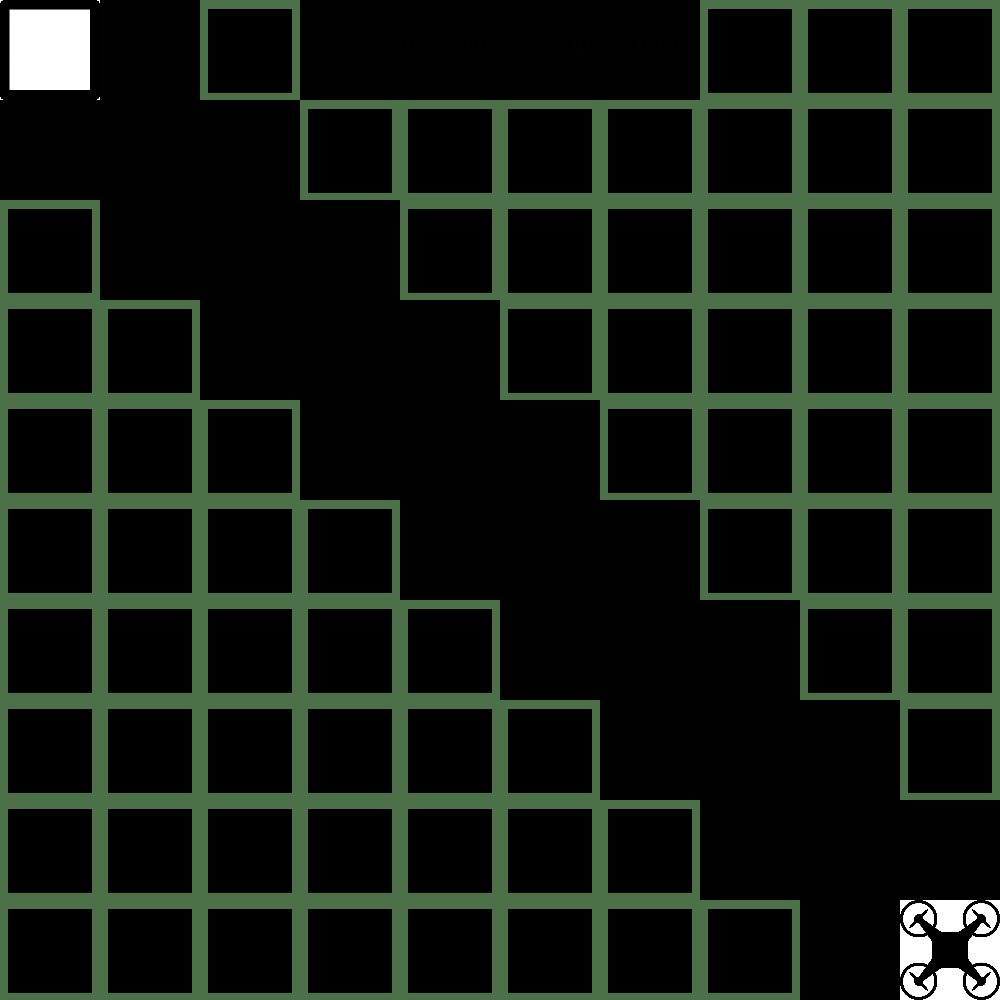

In [ ]:
#!pip install imageio imageio_ffmpeg

import imageio

def record_video(env, Qtable, out_directory, fps=10):
    images = []
    done = False
    canvas, state = env.reset()

    img = env.render()

    images.append(img)


    while True:
    #for each in range(20):

      dis_state = discretize_state(state)
      # Take the action (index) that have the maximum expected future reward given that state
      action = np.argmax(Qtable[dis_state][:])
      canvas, new_state, reward, done, info = env.step(action) # We directly put next_state = state for recording logic
      if new_state == state:
        break
      state = new_state
      img = env.render()
      img = img
      images.append(img)

      if done == True:
        break

    imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)



video_path='/content/drive/MyDrive/RL_for_Fyp/gym-basic/gym_basic/envs/videos/replay.gif'
video_fps=10
record_video(env, Q, video_path, video_fps)

from IPython.display import Image
Image('/content/drive/MyDrive/RL_for_Fyp/gym-basic/gym_basic/envs/videos/replay.gif')
